In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import Spectral
import pickle
from tqdm import tqdm

from matplotlib.backends.backend_pdf import PdfPages
from scipy import signal
import nitime.algorithms as tsa

## AR model

The autoregressive moving-average (ARMA) model for a random process $x[n]$:
$$ x[n] = \sum_{k=1}^{p}a_k x[n-k] + \sum_{k=0}^{q} b_k w[n-k],$$
where
$w[n]$ is white noise with zero mean and variance $\sigma_w^2$.
If all the $a_k$s are zero, $x[n]$ is called a MA linear random process;
if all the $b_k$s are zero, except or $b_0$, then $x[n]$ is called an AR linear random process.

If we take all the $b_k$s be zero except $b_0 = 1$, then we have an AR model:
$$ x[n] = \sum_{k=1}^{p}a_k x[n-k] + w[n],$$
whose power spectrum is given by
$$ S(f) = \frac{\sigma_w^2}{|1-\sum_{k=1}^p a_k e^{-i2\pi k f/f_s}|^2}, $$ 
where
$f_s$ is the sampling frequency.

References:
1. https://www.wikiwand.com/en/Autoregressive%E2%80%93moving-average_model
2. https://www.wikiwand.com/en/Autoregressive_model

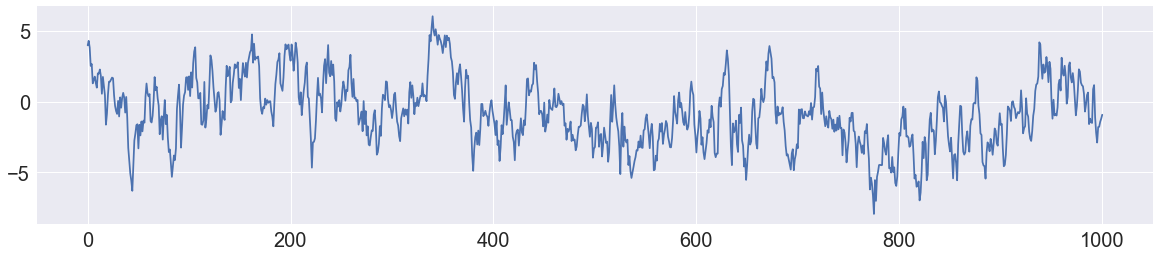

In [2]:
from statsmodels.tsa.arima_process import arma_generate_sample
np.random.seed(2333)

ar = np.array([.9])
ma = np.array([0])

arparams = np.r_[1, -ar]  # add zero-lag and negate
maparams = np.r_[1, ma]  # add zero-lag

to = np.arange(1001)
nobs = np.size(to)
Xo = arma_generate_sample(arparams, maparams, nobs, burnin=50, sigma=1)

sns.set(style="darkgrid", font_scale=2)
plt.subplots(figsize=[20, 4])
plt.plot(to, Xo)

## Two methods: Foster and Kirchner

CPU times: user 2.93 s, sys: 30.8 ms, total: 2.96 s
Wall time: 833 ms
CPU times: user 3.88 s, sys: 41 ms, total: 3.92 s
Wall time: 4.83 s
CPU times: user 9.42 s, sys: 28.7 ms, total: 9.45 s
Wall time: 9.51 s
2.11269460093 4.54136728223e-13


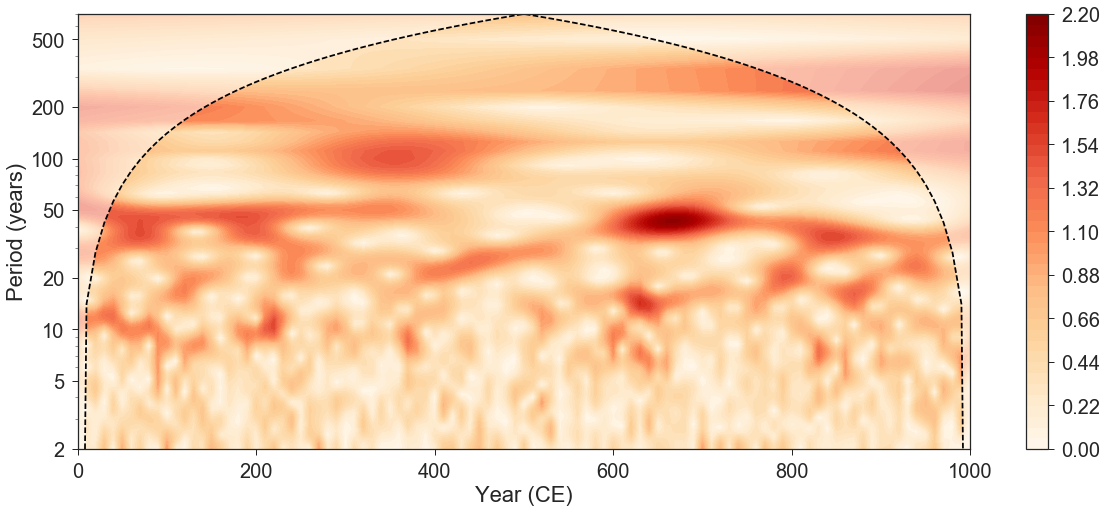

In [56]:
# parameters setup for WWZ

tau = np.linspace(np.min(to), np.max(to), 101)  # evenly-spaced time points
dcon = 1/(8*np.pi**2)  # the delay constant
wa = Spectral.WaveletAnalysis()

freq_ticks = [2, 5, 10, 20, 50, 100, 200, 500]

# Kirchner f2py
%time wwa, phase, AR1_q, coi, freqs, Neffs = Spectral.wwz(Xo, to, tau, c=dcon, nMC=0, nproc=16, standardize=False, detrend=False, method='Kirchner_f2py')

fig = Spectral.plot_wwa(wwa, freqs, tau, coi=coi, AR1_q=AR1_q,
                        levels=np.linspace(0, 2.2, 41), tick_range=np.linspace(0, 2.2, 11),
                        yticks=freq_ticks, ylim=[np.min(freq_ticks), np.max(coi)],
                        plot_cone=True, plot_signif=False,
                       )

# Kirchner nproc
%time wwa_kirchner, phase, AR1_q, coi, freqs, Neffs = Spectral.wwz(Xo, to, tau, c=dcon, nMC=0, nproc=16, standardize=False, detrend=False, method='Kirchner')

# Kirchner basic
%time wwa_kirchner, phase, AR1_q, coi, freqs, Neffs = Spectral.wwz(Xo, to, tau, c=dcon, nMC=0, nproc=1, standardize=False, detrend=False, method='Kirchner')

print(np.max(wwa), np.max(wwa-wwa_kirchner))

CPU times: user 643 ms, sys: 8.08 ms, total: 651 ms
Wall time: 167 ms
CPU times: user 3 s, sys: 29.6 ms, total: 3.03 s
Wall time: 796 ms
CPU times: user 3.01 s, sys: 47 ms, total: 3.06 s
Wall time: 816 ms
CPU times: user 642 ms, sys: 47.2 ms, total: 689 ms
Wall time: 177 ms
CPU times: user 467 µs, sys: 997 µs, total: 1.46 ms
Wall time: 403 µs
CPU times: user 12 ms, sys: 22.9 ms, total: 35 ms
Wall time: 9.58 ms
Analytic: 1.85060232463
CTL: 1.7414418954
Finer tau: 1.7600566301
Finer tau + filter: 1.90419732406
Periodogram: 1.72000153052
MTM: 1.75894783377
CTL + filter: 1.88401287721


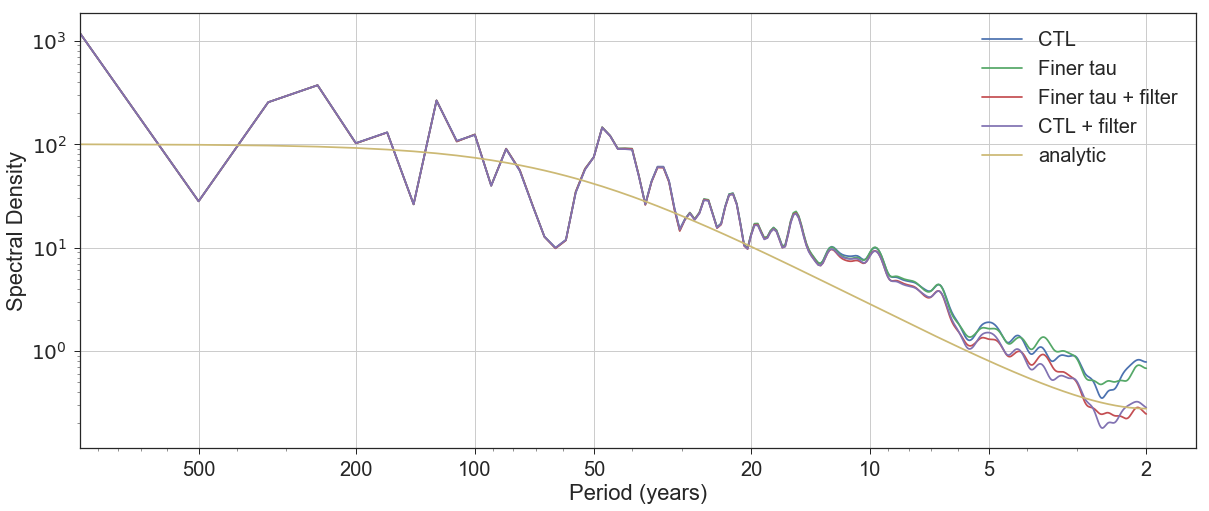

In [58]:
dcon = 1e-3
#dcon = 1/(8*np.pi**2)
#dcon = 1e-2
tau = np.linspace(np.min(to), np.max(to), 21)  # evenly-spaced time points
tau_finer = np.linspace(np.min(to), np.max(to), 101)  # evenly-spaced time points

%time psd_1, freqs = Spectral.wwz_psd(Xo, to, tau, c=dcon, nproc=16, anti_alias=False, method='Kirchner_f2py')
%time psd_2, freqs = Spectral.wwz_psd(Xo, to, tau_finer, c=dcon, nproc=16, anti_alias=False, method='Kirchner_f2py')
%time psd_3, freqs = Spectral.wwz_psd(Xo, to, tau_finer, c=dcon, nproc=16, anti_alias=True, method='Kirchner_f2py')
%time psd_4, freqs = Spectral.wwz_psd(Xo, to, tau, c=dcon, nproc=16, anti_alias=True, method='Kirchner_f2py')

%time freq_periodogram, Pxx_den = signal.periodogram(Xo, 1)
%time freq_mtm, psd_mtm, nu = tsa.multi_taper_psd(Xo, adaptive=False, jackknife=False, NW=1, Fs=1)

fig = Spectral.plot_psd(psd_1, freqs,
                        xticks=freq_ticks,
                        xlim=[np.min(freq_ticks)-0.5, np.max(freq_ticks)+500],
                        label='CTL', #ylim=[1e-2, 1e4],
                        lmstyle='-')
plt.plot(1/freqs, psd_2, '-', label='Finer tau')
plt.plot(1/freqs, psd_3, '-', label='Finer tau + filter')
plt.plot(1/freqs, psd_4, '-', label='CTL + filter')


#plt.plot(1/freq_periodogram[1:], Pxx_den[1:], '-o', label='periodogram')
#plt.plot(1/freq_mtm[1:], psd_mtm[1:], '-', label='mtm', color=sns.xkcd_rgb["greyish"])
psd_ar = wa.psd_ar(1, freqs, ar, 1)
plt.plot(1/freqs, psd_ar, '-', label='analytic')

plt.legend()
#print(np.max(psd_1 - psd_2))

wa = Spectral.WaveletAnalysis()
fmin, fmax = 1/20, 1/5
beta_1, _, _, _ = wa.beta_estimation(psd_1, freqs, fmin, fmax)
beta_2, _, _, _ = wa.beta_estimation(psd_2, freqs, fmin, fmax)
beta_3, _, _, _ = wa.beta_estimation(psd_3, freqs, fmin, fmax)
beta_4, _, _, _ = wa.beta_estimation(Pxx_den[1:], freq_periodogram[1:], fmin, fmax)
beta_5, _, _, _ = wa.beta_estimation(psd_mtm[1:], freq_mtm[1:], fmin, fmax)
beta_6, _, _, _ = wa.beta_estimation(psd_4, freqs, fmin, fmax)


beta_analytic, _, _, _ = wa.beta_estimation(psd_ar, freqs, fmin, fmax)

print('Analytic:', beta_analytic)
print('CTL:', beta_1)
print('Finer tau:', beta_2)
print('Finer tau + filter:', beta_3)
print('Periodogram:', beta_4)
print('MTM:', beta_5)
print('CTL + filter:', beta_6)

## Difference between the methods Foster and Kirchner

64.1097537862 2.11269460093


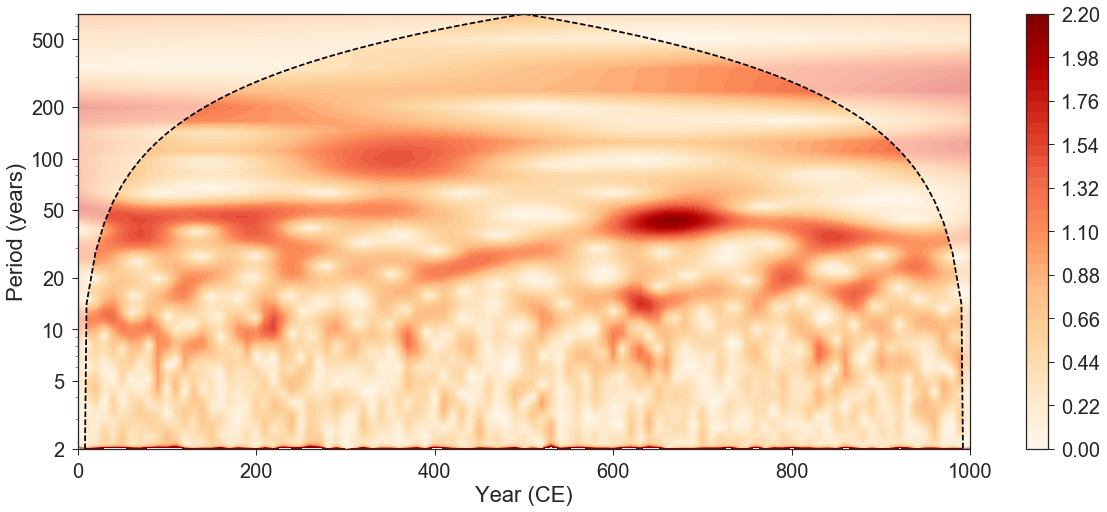

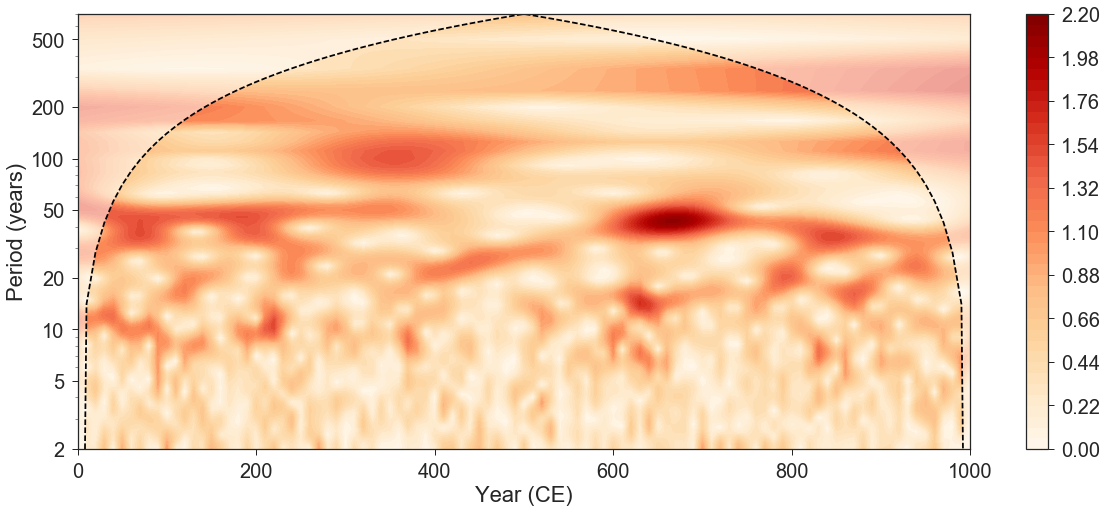

In [24]:
freq_ticks = [2, 5, 10, 20, 50, 100, 200, 500]

# Foster
fig = Spectral.plot_wwa(wwa, freqs, tau, coi=coi, AR1_q=AR1_q,
                        levels=np.linspace(0, 2.2, 41), tick_range=np.linspace(0, 2.2, 11),
                        yticks=freq_ticks, ylim=[np.min(freq_ticks), np.max(coi)],
                        plot_cone=True, plot_signif=False,
                       )
# Kirchner
fig = Spectral.plot_wwa(wwa_kirchner, freqs, tau, coi=coi, AR1_q=AR1_q,
                        levels=np.linspace(0, 2.2, 41), tick_range=np.linspace(0, 2.2, 11),
                        yticks=freq_ticks, ylim=[np.min(freq_ticks), np.max(coi)],
                        plot_cone=True, plot_signif=False,
                       )

print(np.max(wwa), np.max(wwa_kirchner))

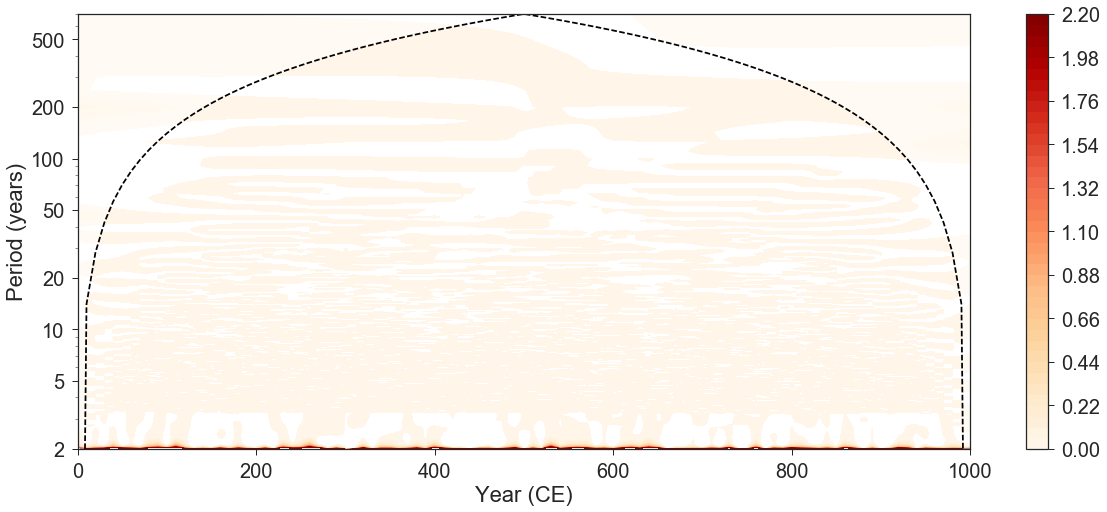

In [25]:
fig = Spectral.plot_wwa(wwa-wwa_kirchner, freqs, tau, coi=coi, AR1_q=AR1_q,
                        levels=np.linspace(0, 2.2, 41), tick_range=np.linspace(0, 2.2, 11),
                        yticks=freq_ticks, ylim=[np.min(freq_ticks), np.max(coi)],
                        plot_cone=True, plot_signif=False,
                       )